# Example 4, critical curves and caustics

For this example we are going to look at a more complicated example, finding the caustics for light passing through the surface of water.  Given the a function {math}`z(\vec{x})` that describes the surface of the water and assuming we have a set of parallel light rays entering at an incident angle {math}`\vec{\theta}_I` we can write down the displacement of the light rays as:

```{math}
\vec{\alpha}(\vec{x}) = (H + z(\vec{x})) \tan\left[\arcsin\left(\frac{n_1}{n_2}\sin(\vec{\theta}_I + \arctan(\nabla_{\vec{x}} z(\vec{x}))\right) - \arctan(\nabla_{\vec{x}} z(\vec{x}))\right]
```

where {math}`H` is the depth of the pool and {math}`n_i` is the index of refraction of air and water (1.0 and 1.33).  The new positions of each ray is give as:

```{math}
\vec{x}_{H} = \vec{x} - \vec{\alpha}
```

The caustics are the locations at the bottom of the pool where a large number of light rays overlap.  We can calculate these locations by looking at the Jacobian of {math}`\vec{x}_{H}` and finding where its determinate is equal to zero.  This determinate is typical called the inverse magnification.  The critical curves are defined by the point on the surface where the inverse magnifications is zero, and the caustics are those same points traced to the bottom of the pool.

```{math}
\frac{1}{\mu} = \det(\nabla_{\vec{x}} \vec{x}_{H})
```

Typically at this point the paraxial approximation is used to simplify the problem, but thankfully with Jax we can easily use auto-differentiation to calculate the tracing function directly from the function for the surface, {math}`z(\vec{x})`, and the inverse magnification from this tracing function.

```{note}
The paraxial approximation assumes that all the angles in the above expression are small (e.g. small waves with near overhead light).  In this case the above expression can be Taylor expanded leading to an inverse magnification of: {math}`\frac{1}{\mu} = \det[I + \frac{n_2 - n_1}{n_2} H \nabla^2 z(\vec{x})]`.
```

In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import matplotlib.colors as colors

from functools import partial
from collections import Counter

from jax_zero_contour import (
    zero_contour_finder,
    split_curves,
    value_and_grad_wrapper
)

## The surface model

For this example we will model the surface as a set of overlapping single ripples each modeled as a `sinc` function.

In [3]:
def single_ripple(x, y):
    # avoid r=0 so the grad is finite
    r = jnp.sqrt(x**2 + y**2 + 1e-15)
    return jnp.sinc(r)


def surface(x, y):
    # make a superposition of multiple ripples
    a = 0.5 * single_ripple(x, y)
    b = 0.4 * single_ripple(0.5*x + 0.75, y)
    c = 0.5 * single_ripple(0.2*x - 1, 0.5 * y)
    return a + b + c

Let's evaluate this surface in a region about the origin and plot it.

In [103]:
n_pix = 1024
x = jnp.linspace(-15, 15, n_pix)
y = jnp.linspace(-9, 9, n_pix)
X, Y = jnp.meshgrid(x, y)

water = surface(X, Y)

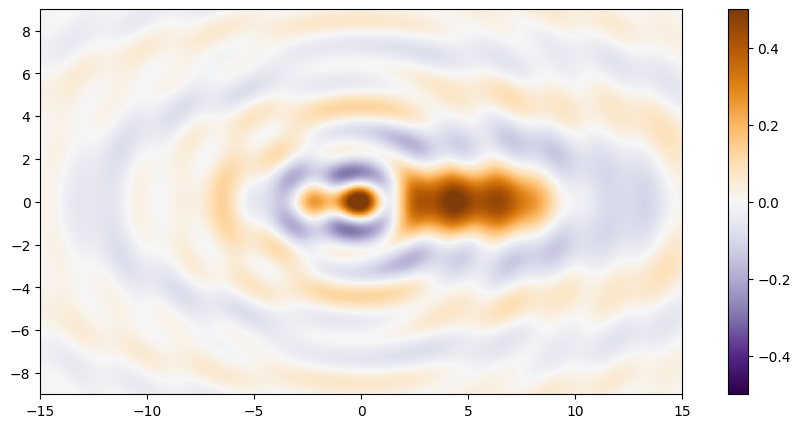

In [104]:
plt.figure(figsize=(12, 5))
plt.imshow(
    water,
    extent=(x.min(), x.max(), y.min(), y.max()),
    vmin=-0.5,
    vmax=0.5,
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar();

## The ray tracing code

Now we can define our tracing and our inverse magnification functions.  In both cases I will make use of `jax.numpy.vectorize` to allow the functions to be evaluated on multiple points at once.

In [336]:
@jax.jit
@partial(jnp.vectorize, signature='(),()->(i)', excluded=(2, 3, 4))
def trace(x, y, H, theta_i, n):
    s_p, dx_p = jax.value_and_grad(surface, argnums=(0, 1))(x, y)
    phi = jnp.arctan(jnp.stack(dx_p))
    theta_1 = theta_i + phi
    theta_2 = jnp.arcsin(jnp.sin(theta_1)/n)
    theta_o = theta_2 - phi
    return jnp.array([x, y]) - (H + s_p) * jnp.tan(theta_o)


@partial(jnp.vectorize, signature='(),()->(i,i)', excluded=(2, 3, 4))
def A(x, y, H, theta_i, n):
    # stack into a 2x2 matrix
    return jnp.stack(jax.jacrev(trace, argnums=(0, 1))(x, y, H, theta_i, n))


def inv_mag(x, y, H, theta_i, n):
    a = A(x, y, H, theta_i, n)
    # because of the vectorization the leading dimensions of 
    # h will be the same shape as the input x and y
    return a[..., 0, 0] * a[..., 1, 1] - a[..., 0, 1] * a[..., 1, 0]

## 1D Visualization

To check that the code is working as intended we will plot a slice of the rays passing through the surface along the x=0 and y=0 slices.

In [337]:
H = 10.0
n = 1.33
theta_i = jnp.array([-1.0, 0.0])
t = trace(X, Y, H, theta_i, n)
inv_mag_droplet = inv_mag(X, Y, H, theta_i, n)

In [117]:
n_half = n_pix//2
# slice in the x direction
# incoming light at angle theta_i[0]
x_slice_incoming_x = jnp.vstack([x + 10 * jnp.sin(theta_i[0]), x])
x_slice_incoming_y = jnp.vstack([water[n_half, :] + 10 * jnp.cos(theta_i[0]), water[n_half, :]])
# outgoing light rays
x_slice_outgoing_x = jnp.vstack([x, t[n_half, :, 0]])
x_slice_outgoing_y = jnp.vstack([water[n_half, :], -H * jnp.ones_like(x)])

# slice in the y direction
# incoming light at angle theta_i[1]
y_slice_incoming_x = jnp.vstack([y + 10 * jnp.sin(theta_i[1]), y])
y_slice_incoming_y = jnp.vstack([water[:, n_half] + 10 * jnp.cos(theta_i[1]), water[:, n_half]])
# outgoing light rays
y_slice_outgoing_x = jnp.vstack([y, t[:, n_half, 1]])
y_slice_outgoing_y = jnp.vstack([water[:, n_half], -H * jnp.ones_like(y)])

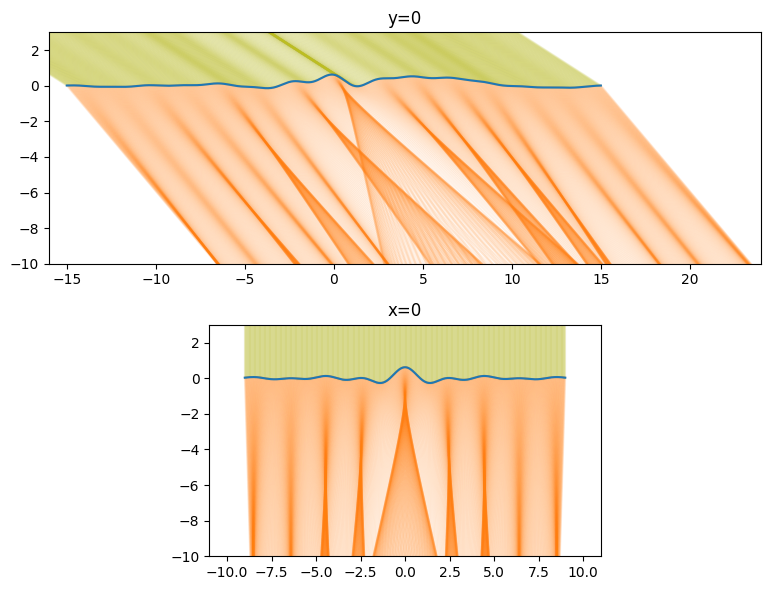

In [122]:
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.plot(x_slice_incoming_x, x_slice_incoming_y, 'C8', alpha=0.1)
plt.plot(x_slice_outgoing_x, x_slice_outgoing_y, color='C1', alpha=0.1)
plt.plot(x, water[512, :])
plt.xlim(-16, 24)
plt.ylim(-H, 3)
plt.gca().set_aspect(1)
plt.title('y=0')

plt.subplot(212)
plt.plot(y_slice_incoming_x, y_slice_incoming_y, 'C8', alpha=0.1)
plt.plot(y_slice_outgoing_x, y_slice_outgoing_y, color='C1', alpha=0.1)
plt.plot(y, water[:, 512])
plt.xlim(-11, 11)
plt.ylim(-H, 3)
plt.gca().set_aspect(1)
plt.title('x=0')
plt.tight_layout();

Everything looks like it working as intended.  Places where the surface is convex the light rays get focused, and where it is concave the light rays diverge.

## 2D Visualization

These 1D slides only tell part of the story, if we instead plot where the full grid of points across the top of the surface traced onto the bottom of the pool we will see even more patterns.

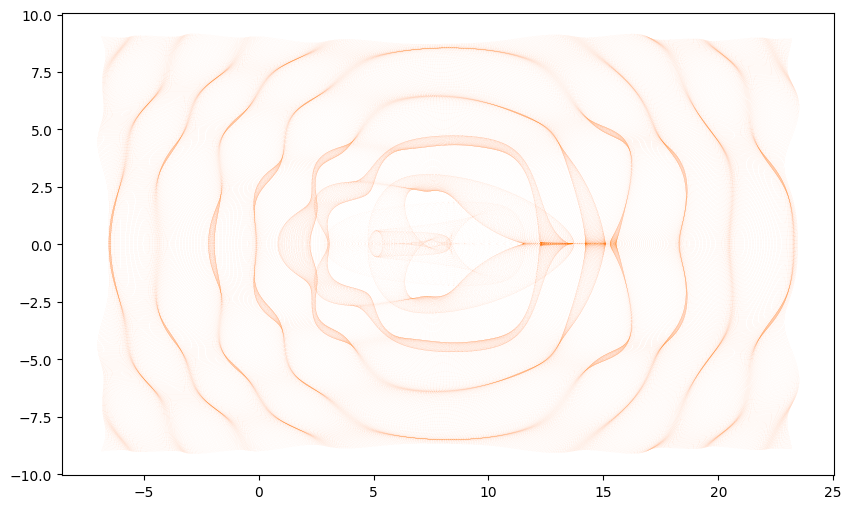

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(t[..., 0].flatten(), t[..., 1].flatten(), ',', color='C1', alpha=0.01)
plt.gca().set_aspect(1);

## Critical curves

Our goal is to find the curves that follow where the magnification ({math}`\mu`) of the light will be the largest, or equivalently, where {math}`\frac{1}{\mu}` is zero.  Les't plot the inverse magnification for our system.

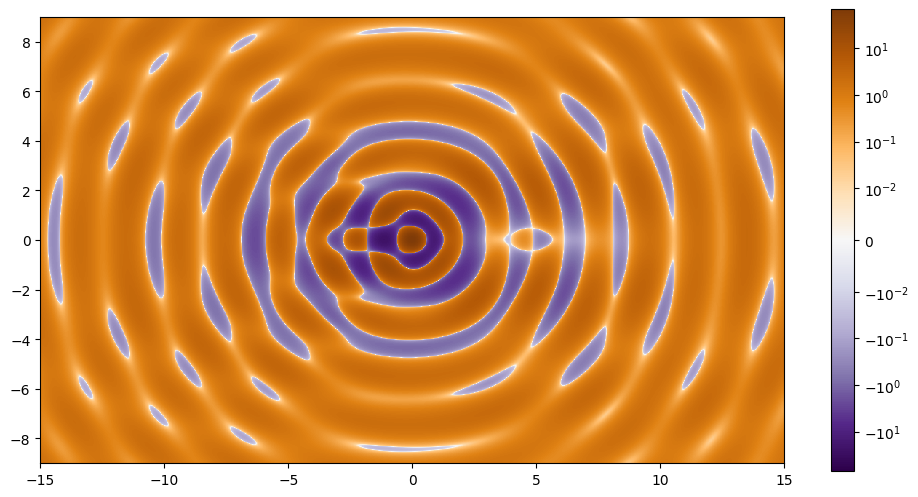

In [210]:
plt.figure(figsize=(12, 6))
plt.imshow(
    inv_mag_droplet,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.01, vmin=-70, vmax=70),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar();

We can see there are multiple critical curves for this function.  We will need to pick an initial point near each of them so we can run the zero finder.

```{note}
There can be a bit of trial and error to find initial points that land on each of the critical curves.
```

In [124]:
v_and_g_inv_mag = value_and_grad_wrapper(partial(inv_mag, H=H, theta_i=theta_i, n=n))

In [ ]:
staring_points = jnp.array([
    [-15.0, 0.0],
    [-14.0, 6.0], [-14.0, -6.0],
    [-11.0, 4.0], [-11.0, -4.0],
    [-10.0, 7.0], [-10.0, -7.0], [-10.0, 0.0], [-10.0, 5.0], [-10.0, -5.0],
    [-6.0, 8.0], [-6.0, -8.0], [-6.0, 5.0], [-6.0, -5.0], [-6.0, 0.0],
    [-8.0, 2.0], [-8.0, -2.0],
    [-5.0, 0.0],
    [-4.0, 0.0],
    [-2.0, 0.0],
    [0.0, 2.0], [0.0, 3.0], [0.0, 0.5], [0.0, 8.0], [0.0, -8.0],
    [2.0, 6.0], [2.0, -6.0],
    [5.0, 0.0],
    [6.0, 0.0],
    [7.0, 6.0], [7.0, -6.0],
    [8.0, 0.0],
    [10.0, 2.0], [10.0, -2.0],
    [11.0, 6.0], [11.0, -6.0],
    [14.0, 2.0], [14.0, -2.0]
])

paths = []
values = []
stopping_conditions = []

for start in staring_points:
    p, v, s = zero_contour_finder(
        v_and_g_inv_mag,
        start,
        delta=0.01,
        max_iter=20,
        tol=1e-12
    )
    paths.append(p)
    values.append(v)
    stopping_conditions.append(s)

# unique stopping conditions
print(Counter([tuple(s.tolist()) for s in stopping_conditions]))

# maximum deviation from zero along any contour
jnp.array([jnp.abs(v).max() for v in values]).max()


{(0, 2), (2,)}


Array(3.68099648e-14, dtype=float64)

Looks like all our contours formed closed loops as expected.  Let's plot the results.

In [618]:
# because we have a large number of contours, define a 20-long color cycle
cm = plt.get_cmap('tab20b')
color_cycle = [cm(i/20) for i in range(20)]

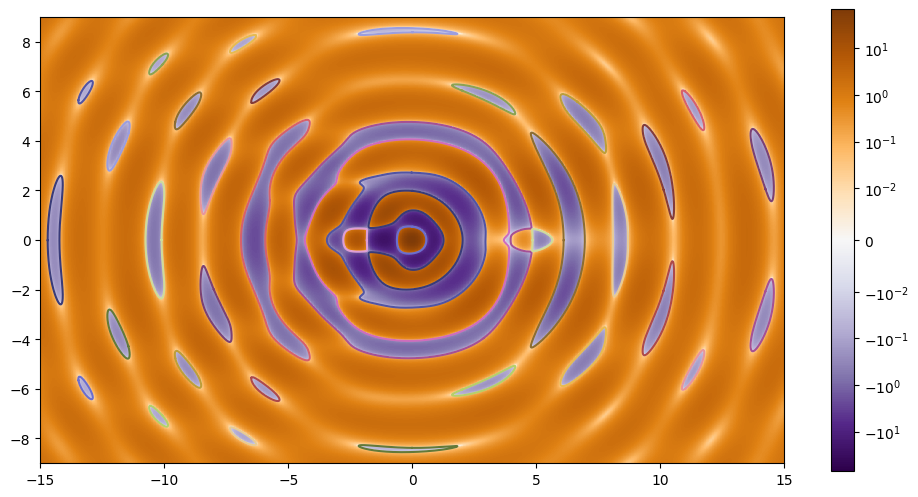

In [629]:
plt.figure(figsize=(12, 6))
plt.imshow(
    inv_mag_droplet,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.01, vmin=-70, vmax=70),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar()

plt.gca().set_prop_cycle(color=color_cycle)
for p in paths:
    plt.plot(*p.T);

## Caustics

If we trace these curves to the bottom of the pool will will have the curves describing the caustics.

```{note}
Depending on the nature of the lensing system, sometimes the critical curve can be "split" when traced into a caustic.  In these cases plotting the caustics as lines cause artifacts, in these cases the `split_curves` function can be used to split a list of points into multiple arrays whenever there is a jump from on point to the next that is larger than a given `threshold` value.
```

In [340]:
caustics = [trace(*jnp.vstack(p).T, H, theta_i, n) for p in paths]

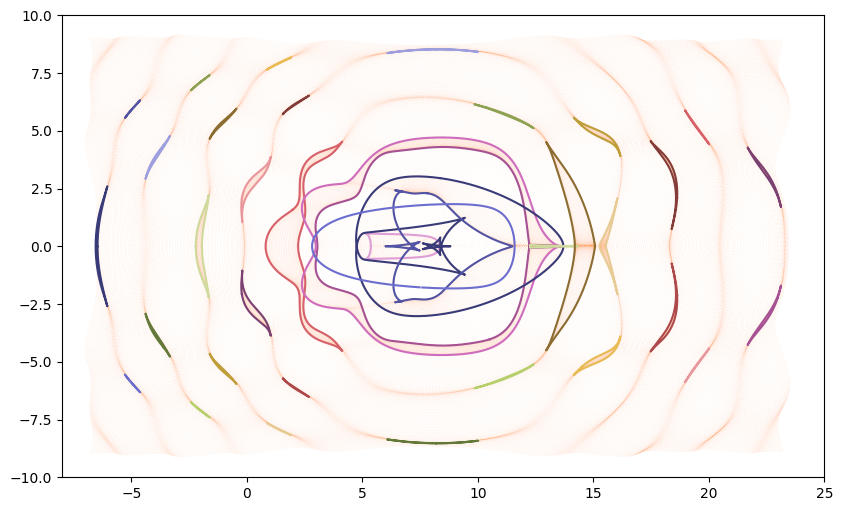

In [620]:
plt.figure(figsize=(12, 6))
plt.plot(t[..., 0].flatten(), t[..., 1].flatten(), ',', color='C1', alpha=0.01)
plt.gca().set_prop_cycle(color=color_cycle)
for c in caustics:
    plt.plot(*c.T)
plt.xlim(-8, 25)
plt.ylim(-10, 10)
plt.gca().set_aspect(1);

As expected our caustics match up with the places our grid points "bunch up."

## Eigenvalue decomposition

What does it mean for the determinate of the Jacobian of {math}`\vec{x}_{H}` to be zero?  This happens when at least one if Jacobian's eigenvalues are zero.  In lensing these eigenvalues are called the tangential and radial eigenvalues, and where they are equal to zero we have the tangential and radial critical curves.

```{note}
These names come form direction the light is squeezed at these point.  On a radial critical point the light is squeezed together in the radial direction, on a tangential critical point the light is squeezed in the angular direction (e.g. tangential to the radial direction).
```

At this point we can directly calculate functions for these two eigenvalues and run the code `zero_contour_finder` on the result, but we would run into one issue: because this Jacobian is not guaranteed to be symmetric, these eigenvalues could (and in this example do) become complex.  To avoid this, we instead make use of the fact that this Jacobian can be written as a diagonal matrix multiplied on either side by different rotation matrices.

```{math}
A = Rot(-\phi) \begin{pmatrix}
  \lambda_1 & 0 \\
  0 & \lambda_2
\end{pmatrix} Rot(\theta)
```

For lack of a better name, let's call {math}`\lambda_1` and {math}`\lambda_2` the pseudo-eigenvalues because they have the same zeros as the true eigenvalues, but are always real-valued (but not always continuous).

Let's write down the code for calculating these values directly from the Jacobian:

In [348]:
@partial(jax.jit, static_argnums=(5,))
def eigen_value(x, y, H, theta_i, n, kind='tangential'):
    # kind is either 'tangential' or 'radial'
    # the equation only differs by a sign on the last line
    sign = jax.lax.select(kind=='tangential', 1, -1)
    a = A(x, y, H, theta_i, n)

    trace = a[..., 0, 0] + a[..., 1, 1]
    anti_trace2 = (a[..., 1, 0] + a[..., 0, 1])**2
    diag_diff2 = (a[..., 0, 0] - a[..., 1, 1])**2
    anti_diag_diff2 = (a[..., 1, 0] - a[..., 0, 1])**2
    
    term1 = 0.5 * jnp.sign(trace) * jnp.sqrt(trace**2 + anti_diag_diff2)
    term2 = 0.5 * jnp.sqrt(diag_diff2 + anti_trace2)
    return term1 - sign * term2

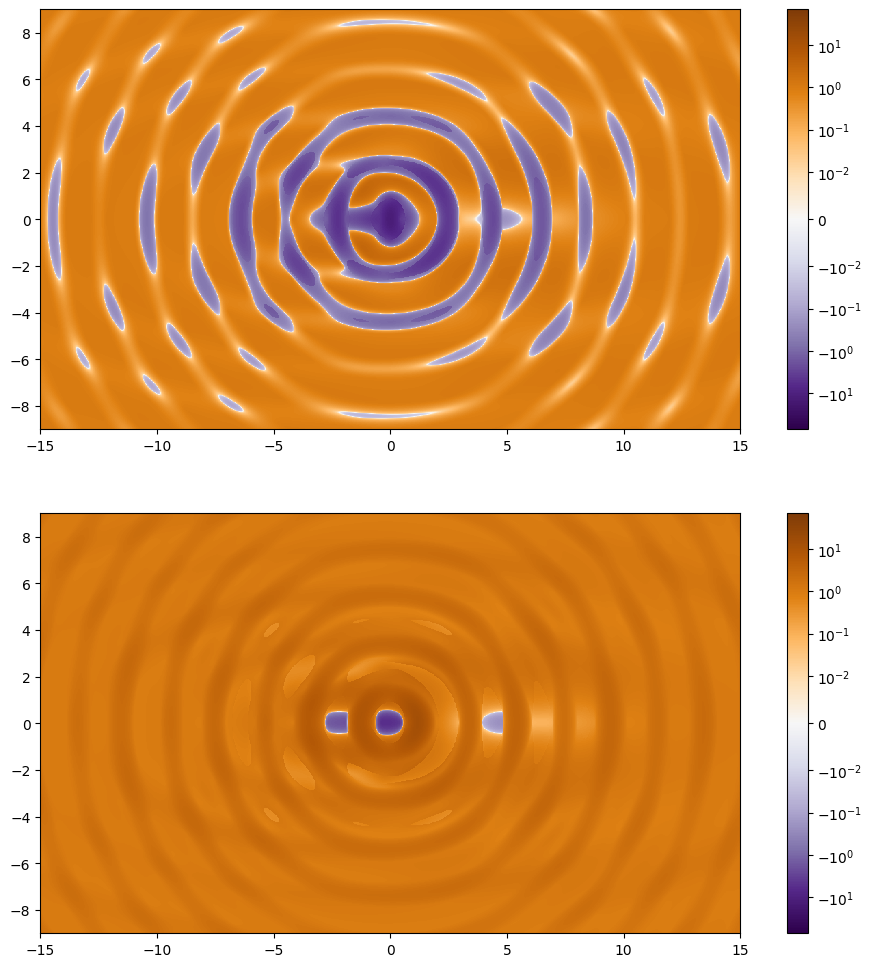

In [358]:
et = eigen_value(X, Y, H, theta_i, n, kind='tangential')
er = eigen_value(X, Y, H, theta_i, n, kind='radial')

plt.figure(figsize=(12, 12))
plt.subplot(211)
plt.imshow(
    et,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.01, vmin=-70, vmax=70),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar()

plt.subplot(212)
plt.imshow(
    er,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.01, vmin=-70, vmax=70),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar();

### Radial and tangential critical curves

At this point we can see that these function are no longer continuous and around the point `(5, 0)` we can see that the discontinuity passes over the zero contours.  As before we can run the zero finding code on each of these maps.

In [ ]:
v_and_g_inv_mag_tangential = value_and_grad_wrapper(
    partial(eigen_value, H=H, theta_i=theta_i, n=n, kind='tangential')
)
v_and_g_inv_mag_radial = value_and_grad_wrapper(
    partial(eigen_value, H=H, theta_i=theta_i, n=n, kind='radial')
)

In [526]:
staring_points_tangential = jnp.array([
    [-15.0, 0.0],
    [-13.0, 6.0], [-13.0, -6.0],
    [-12.0, 4.0], [-12.0, -4.0],
    [-10.0, 7.0], [-10.0, -7.0], [-10.0, 0.0], 
    [-9.0, 5.0], [-9.0, -5.0], [-9.0, 2.0], [-9.0, -2.0], 
    [-6.0, 8.0], [-6.0, -8.0],  [-6.0, 0.0],
    [-5.5, 6.0], [-5.5, -6.0],
    [-2.0, 0.0], [-2.0, 2.0],
    [0.0, 2.0], [0.0, 4.0], [0.0, 8.0], [0.0, -8.0],
    [2.0, 6.0], [2.0, -6.0],
    [5.0, 0.0],
    [5.5, 2.0],
    [7.0, 5.0], [7.0, -5.0],
    [8.0, 1.0],
    [10.0, 2.0], [10.0, -2.0],
    [11.0, 6.0], [11.0, -6.0],
    [14.0, 2.0], [14.0, -2.0]
])

paths_tangential = []
values_tangential = []
stopping_conditions_tangential = []

for start in staring_points_tangential:
    p, v, s = zero_contour_finder(
        v_and_g_inv_mag_tangential,
        start,
        delta=0.01,
        max_iter=20,
        tol=1e-14
    )
    paths_tangential.append(p)
    values_tangential.append(v)
    stopping_conditions_tangential.append(s)

# unique stopping conditions
print(Counter([tuple(s.tolist()) for s in stopping_conditions_tangential]))

# maximum deviation from zero along any contour
jnp.array([jnp.abs(v).max() for v in values_tangential]).max()

Counter({(2,): 32, (0, 2): 2, (1, 1): 2})


Array(9.99200722e-15, dtype=float64)

Unlike before we have two curves that terminated with `[1, 1]` indicating that those contours have "end points" rather than being closed.

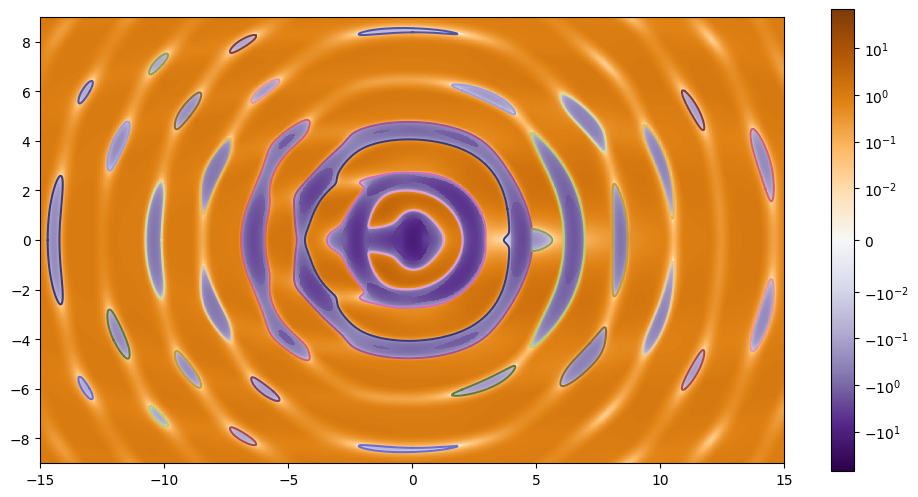

In [631]:
plt.figure(figsize=(12, 6))
plt.imshow(
    et,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.01, vmin=-70, vmax=70),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar()

plt.gca().set_prop_cycle(color=color_cycle)
for p in paths_tangential:
    plt.plot(*p.T);

Looking at the above plot looks like the two contours that are not closed might join up, but if we zoom in we can see that indeed they are different curves.

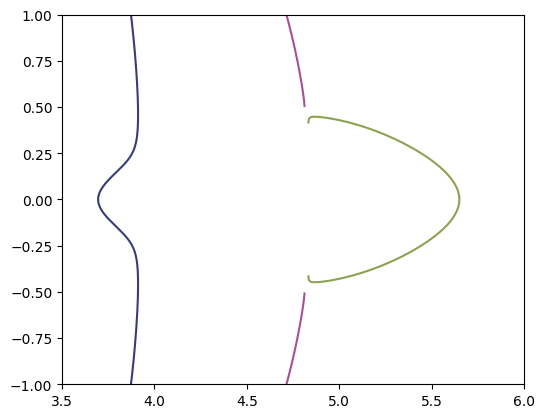

In [644]:
plt.gca().set_prop_cycle(color=color_cycle)
for p in paths_tangential:
    plt.plot(*p.T)

plt.gca().set_aspect(1)
plt.xlim(3.5, 6)
plt.ylim(-1, 1);

We can similarly do this for the radial critical curves.

In [622]:
staring_points_radial = jnp.array([
    [-2.5, 1.0], [0.0, 1.0], [4.0, 1.0],
    [4.9, 0.0]
])

paths_radial = []
values_radial = []
stopping_conditions_radial = []

for start in staring_points_radial:
    p, v, s = zero_contour_finder(
        v_and_g_inv_mag_radial,
        start,
        delta=0.01,
        max_iter=20,
        tol=1e-14
    )
    paths_radial.append(p)
    values_radial.append(v)
    stopping_conditions_radial.append(s)

# unique stopping conditions
print(Counter([tuple(s.tolist()) for s in stopping_conditions_radial]))

# maximum deviation from zero along any contour
jnp.array([jnp.abs(v).max() for v in values_radial]).max()

Counter({(2,): 2, (1, 1): 2})


Array(1.19099175e-13, dtype=float64)

Again we see that two of the critical curves are not closed.

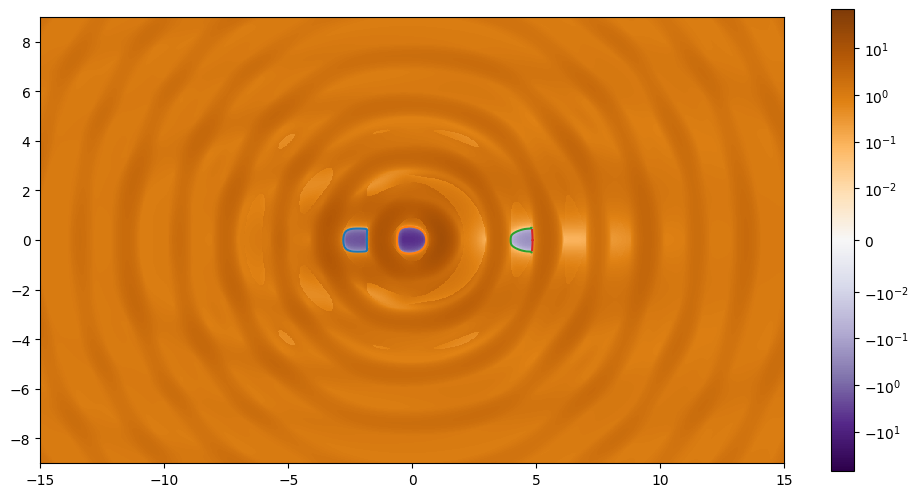

In [633]:
plt.figure(figsize=(12, 6))
plt.imshow(
    er,
    extent=(x.min(), x.max(), y.min(), y.max()),
    norm=colors.SymLogNorm(linthresh=0.01, vmin=-70, vmax=70),
    cmap='PuOr_r',
    origin='lower',
    interpolation='nearest'
)
plt.colorbar()

for p in paths_radial:
    plt.plot(*p.T);

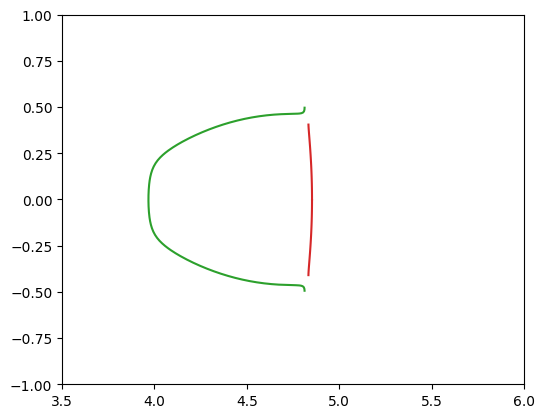

In [645]:
for p in paths_radial:
    plt.plot(*p.T)

plt.gca().set_aspect(1)
plt.xlim(3.5, 6)
plt.ylim(-1, 1);

As before, after zooming in to the non-closed contours we can see they are different curves.  If we place both the tangential and radial critical curves in the same plot at this point we will see that they define sections of the contours we found before:

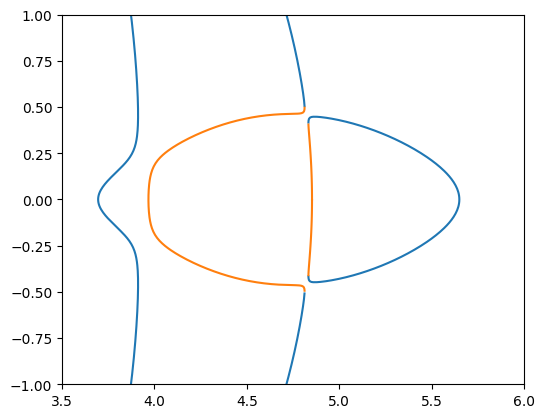

In [646]:
for p in paths_tangential:
    plt.plot(*p.T, color='C0')

for p in paths_radial:
    plt.plot(*p.T, color='C1')

plt.gca().set_aspect(1)
plt.xlim(3.5, 6)
plt.ylim(-1, 1);

### Radial and tangential caustics

Finally we can take our decomposed critical curves and trace them into caustics.

```{note}
Depending on the nature of the lensing system, sometimes the critical curve can be "split" when traced into a caustic.  In these cases plotting the caustics as lines cause artifacts, in these cases the `split_curves` function can be used to split a list of points into multiple arrays whenever there is a jump from on point to the next that is larger than a given `threshold` value.
```

In [534]:
caustics_radial = [trace(*jnp.vstack(p).T, H, theta_i, n) for p in paths_radial]
caustics_tangential = [trace(*jnp.vstack(p).T, H, theta_i, n) for p in paths_tangential]

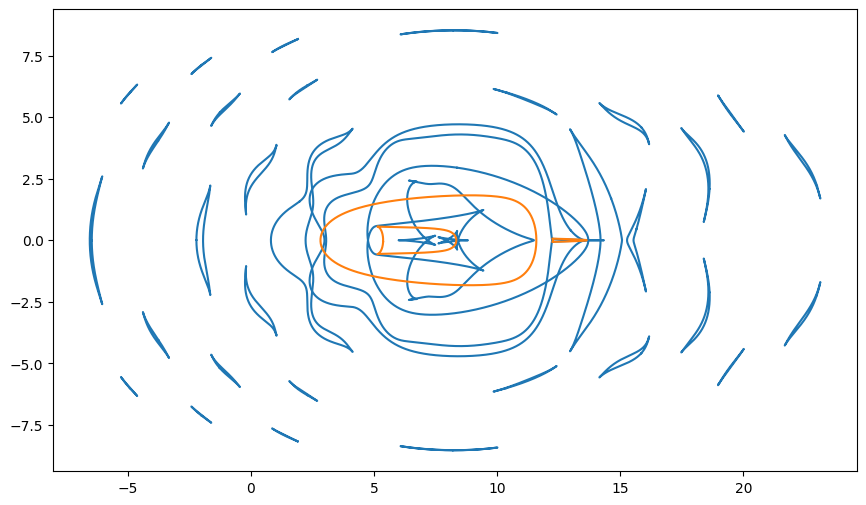

In [625]:
plt.figure(figsize=(12, 6))
plt.gca().set_prop_cycle(color=color_cycle)
for ct in caustics_tangential:
    plt.plot(*ct.T, color='C0')

for cr in caustics_radial:
    plt.plot(*cr.T, color='C1')

plt.gca().set_aspect(1)